# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

In [2]:
data = pd.read_csv("./data/ratings_Beauty.csv")

In [3]:
data.columns

Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')

- the unique UserId (Customer Identification),
- the product ASIN (Amazon's unique product identification code for each product),
- Ratings (ranging from 1-5 based on customer satisfaction) and
- the Timestamp of the rating in UNIX time (the unix time stamp is the number of seconds between a particular date and the Unix Epoch aka January 1st, 1970 at UTC)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [5]:
data.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


In [6]:
# Convert the UNIX timestamp to a human-readable format
data["Datetime"] = pd.to_datetime(data["Timestamp"], unit="s")

In [7]:
# Extract year and month from the timestamp
data["Year"] = data["Datetime"].dt.year
data["Month"] = data["Datetime"].dt.strftime("%b")

In [8]:
data.head()

,UserId,ProductId,Rating,Timestamp,Datetime,Year,Month
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,2013-05-28,2013,May
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,2012-12-14,2012,Dec
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2014-07-07,2014,Jul
3,A1WMRR494NWEWV,0733001998,4.0,1382572800,2013-10-24,2013,Oct
4,A3IAAVS479H7M7,0737104473,1.0,1274227200,2010-05-19,2010,May


In [9]:
data.tail()

,UserId,ProductId,Rating,Timestamp,Datetime,Year,Month
2023065,A3DEHKPFANB8VA,B00LORWRJA,5.0,1405296000,2014-07-14,2014,Jul
2023066,A3DEHKPFANB8VA,B00LOS7MEE,5.0,1405296000,2014-07-14,2014,Jul
2023067,AG9TJLJUN5OM3,B00LP2YB8E,5.0,1405382400,2014-07-15,2014,Jul
2023068,AYBIB14QOI9PC,B00LPVG6V0,5.0,1405555200,2014-07-17,2014,Jul
2023069,A1PB6OT0OOPKNQ,B00LU0LTOU,5.0,1405641600,2014-07-18,2014,Jul


# Analysis of the dataset

## Missing values ?

In [10]:
# Columns with missing values are :
columns_with_missing_values = data.columns[data.isna().any()].tolist()
if columns_with_missing_values == []:
    print("No missing values in the dataset ^-^ !")
else:
    columns_with_missing_values

No missing values in the dataset ^-^ !


## General analysis 

In [11]:
# DataFrame for customer purchases
customer_purchases = pd.DataFrame(
    data.groupby("UserId")["ProductId"].count().reset_index()
)
customer_purchases.columns = ["UserId", "TotalPurchases"]

In [12]:
customer_purchases.head()

,UserId,TotalPurchases
0,A00008821J0F472NDY6A2,1
1,A000186437REL8X2RW8UW,1
2,A0002574WYJMBWKNCPY8,1
3,A00029263J863WSR0TDRS,1
4,A00031961JI1CBNV98TW,1


In [13]:
# Group by TotalPurchases and count the number of customers
customers_per_purchase = (
    customer_purchases.groupby("TotalPurchases")["UserId"].count().reset_index()
)

In [14]:
customers_per_purchase[customers_per_purchase["TotalPurchases"] == 1]

,TotalPurchases,UserId
0,1,887401


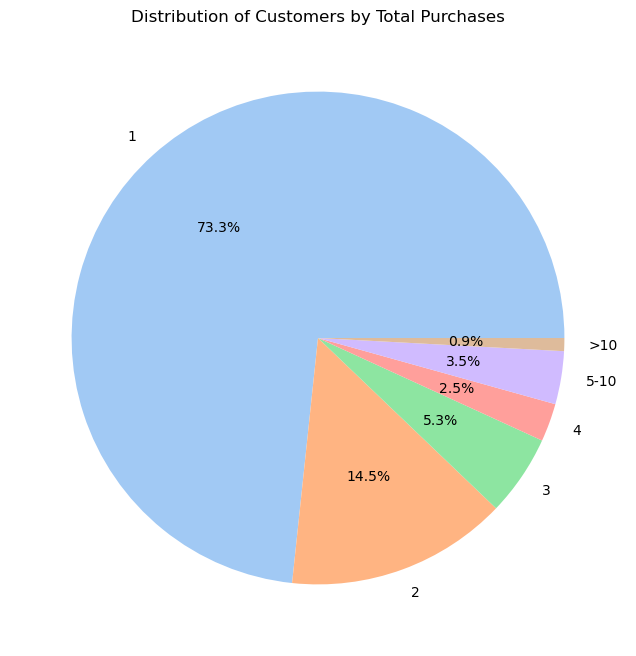

In [15]:
# Define the bins for TotalPurchases
bins = [0, 1, 2, 3, 4, 10, float("inf")]

# Create bins and count the number of customers in each bin
customer_purchases["PurchaseGroup"] = pd.cut(
    customer_purchases["TotalPurchases"],
    bins=bins,
    labels=["1", "2", "3", "4", "5-10", ">10"],
)
purchase_group_counts = customer_purchases["PurchaseGroup"].value_counts().sort_index()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    purchase_group_counts,
    labels=purchase_group_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel"),
)
plt.title("Distribution of Customers by Total Purchases")
plt.show()

## Studying the data yearly

In [16]:
# Create a DataFrame with columns for :
# the number of sold products, customers per year and
# the number of customer who made more than one purchase
# the number of products purchased more than once
yearly_data = pd.DataFrame(
    {
        "Year": data.groupby("Year").size().index,
        "TotalCounts": data.groupby("Year").size(),
        "UniqueProducts": data.groupby("Year")["ProductId"].nunique(),
        "RepeatedProducts": data.groupby("Year")["ProductId"].apply(
            lambda x: sum(x.duplicated())
        ),
        "UniqueCustomers": data.groupby("Year")["UserId"].nunique(),
        "RepeatedCustomers": data.groupby("Year")["UserId"].apply(
            lambda x: sum(x.duplicated())
        ),
    }
).reset_index(drop=True)

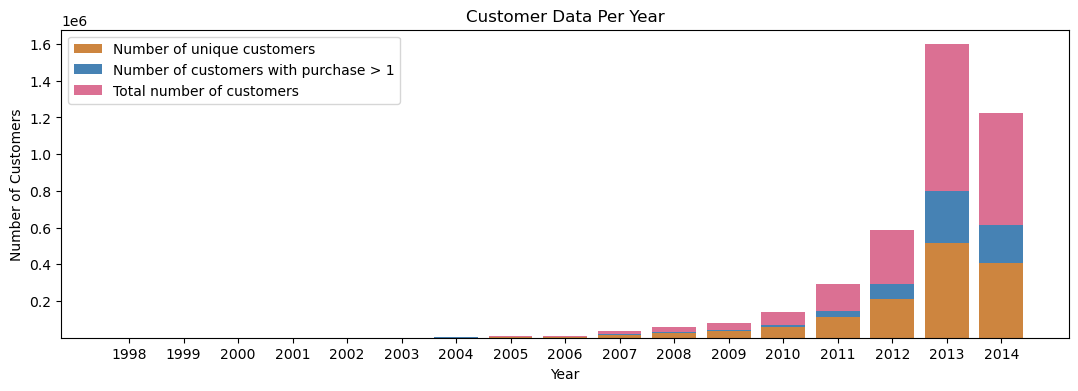

In [17]:
# Plot the stacked bar plot for customer data using yearly_data
plt.figure(figsize=(13, 4))

# Plot the number of unique customers
plt.bar(
    yearly_data["Year"],
    yearly_data["UniqueCustomers"],
    color="peru",
    label="Number of unique customers",
)
# Plot the number of repeated customers on top of the unique
plt.bar(
    yearly_data["Year"],
    yearly_data["RepeatedCustomers"],
    bottom=yearly_data["UniqueCustomers"],
    color="steelblue",
    label="Number of customers with purchase > 1",
)
# Plot the total number of customers on top of everything
plt.bar(
    yearly_data["Year"],
    yearly_data["TotalCounts"],
    bottom=yearly_data["UniqueCustomers"] + yearly_data["RepeatedCustomers"],
    color="palevioletred",
    label="Total number of customers",
)

plt.title("Customer Data Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Customers")
plt.legend()
plt.xticks(yearly_data["Year"].astype(int))  # to avoid float years
plt.show()

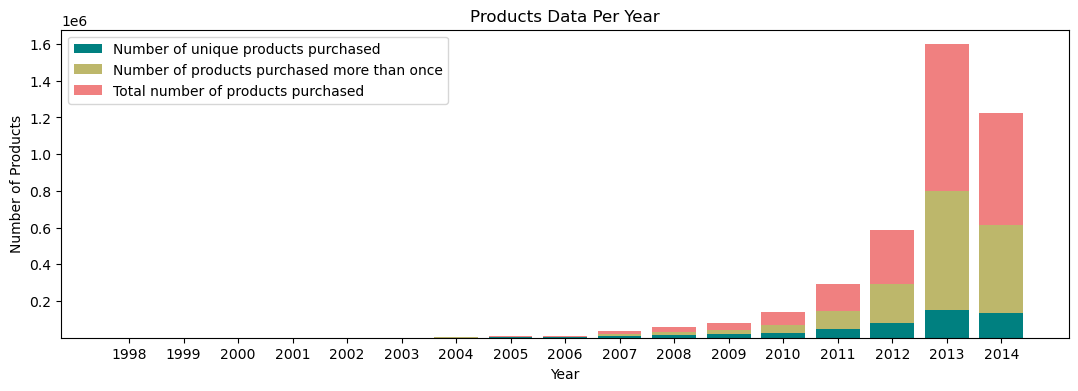

In [18]:
# Plot the stacked bar plot for products data
plt.figure(figsize=(13, 4))


# Plot the number of unique products
plt.bar(
    yearly_data["Year"],
    yearly_data["UniqueProducts"],
    color="teal",
    label="Number of unique products purchased",
)
# Plot the number of repeated products on top of the unique
plt.bar(
    yearly_data["Year"],
    yearly_data["RepeatedProducts"],
    bottom=yearly_data["UniqueProducts"],
    color="darkkhaki",
    label="Number of products purchased more than once",
)
# Plot the total number of products on top of everything
plt.bar(
    yearly_data["Year"],
    yearly_data["TotalCounts"],
    bottom=yearly_data["UniqueProducts"] + yearly_data["RepeatedProducts"],
    color="lightcoral",
    label="Total number of products purchased",
)

plt.title("Products Data Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Products")
plt.legend()
plt.xticks(yearly_data["Year"].astype(int))  # to avoid float years
plt.show()

## Ratings analysis

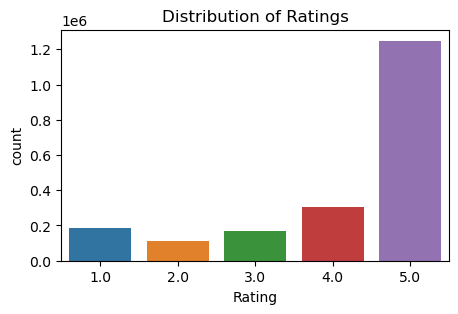

In [19]:
# Visualize the distribution of ratings
plt.figure(figsize=(5, 3))
sns.countplot(x="Rating", data=data)
plt.title("Distribution of Ratings")
plt.show()

In [20]:
# Explore the number of ratings per year and month
ratings_per_month = pd.DataFrame(
    data.groupby(["Year", "Month"])["Rating"].count().reset_index()
)

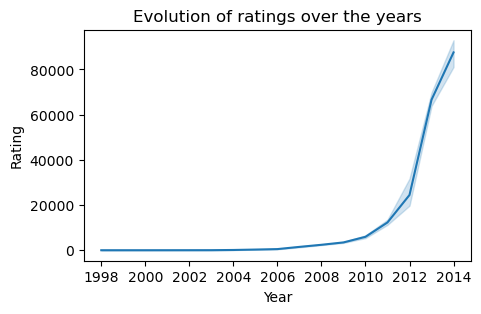

In [21]:
plt.figure(figsize=(5, 3))
sns.lineplot(data=ratings_per_month, x="Year", y="Rating")
plt.title("Evolution of ratings over the years")
plt.show()

In [22]:
# Filter the ratings_per_month DataFrame for years 2010 to 2014
ratings_per_month_filtered = ratings_per_month[
    (ratings_per_month["Year"] >= 2010) & (ratings_per_month["Year"] <= 2014)
]

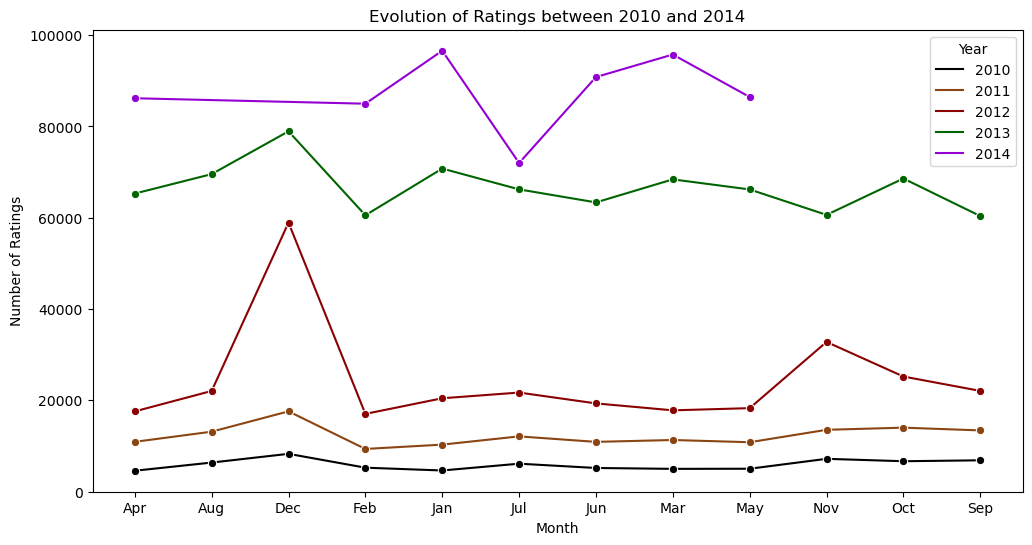

In [23]:
# Set the Seaborn palette
year_colors = {
    2010: "black",
    2011: "saddlebrown",
    2012: "darkred",
    2013: "darkgreen",
    2014: "darkviolet",
}

# Plot the evolution of ratings between 2010 and 2014
plt.figure(figsize=(12, 6))
sns.lineplot(
    x="Month",
    y="Rating",
    hue="Year",
    data=ratings_per_month_filtered,
    marker="o",
    palette=year_colors,
)
plt.title("Evolution of Ratings between 2010 and 2014")
plt.xlabel("Month")
plt.ylabel("Number of Ratings")
plt.legend(title="Year")
plt.show()

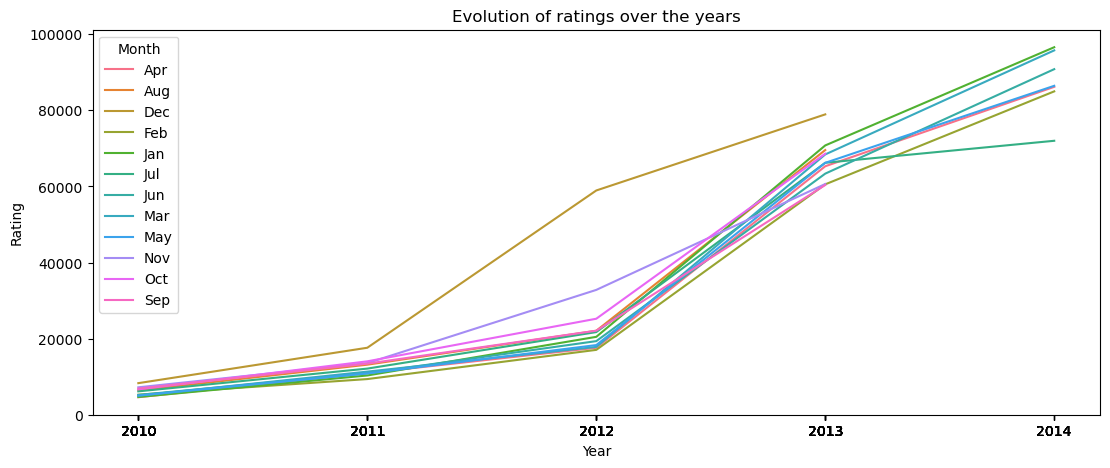

In [24]:
plt.figure(figsize=(13, 5))
sns.lineplot(data=ratings_per_month_filtered, x="Year", y="Rating", hue="Month")
plt.title("Evolution of ratings over the years")
plt.xticks(ratings_per_month_filtered["Year"].astype(int))  # to avoid float years
plt.show()

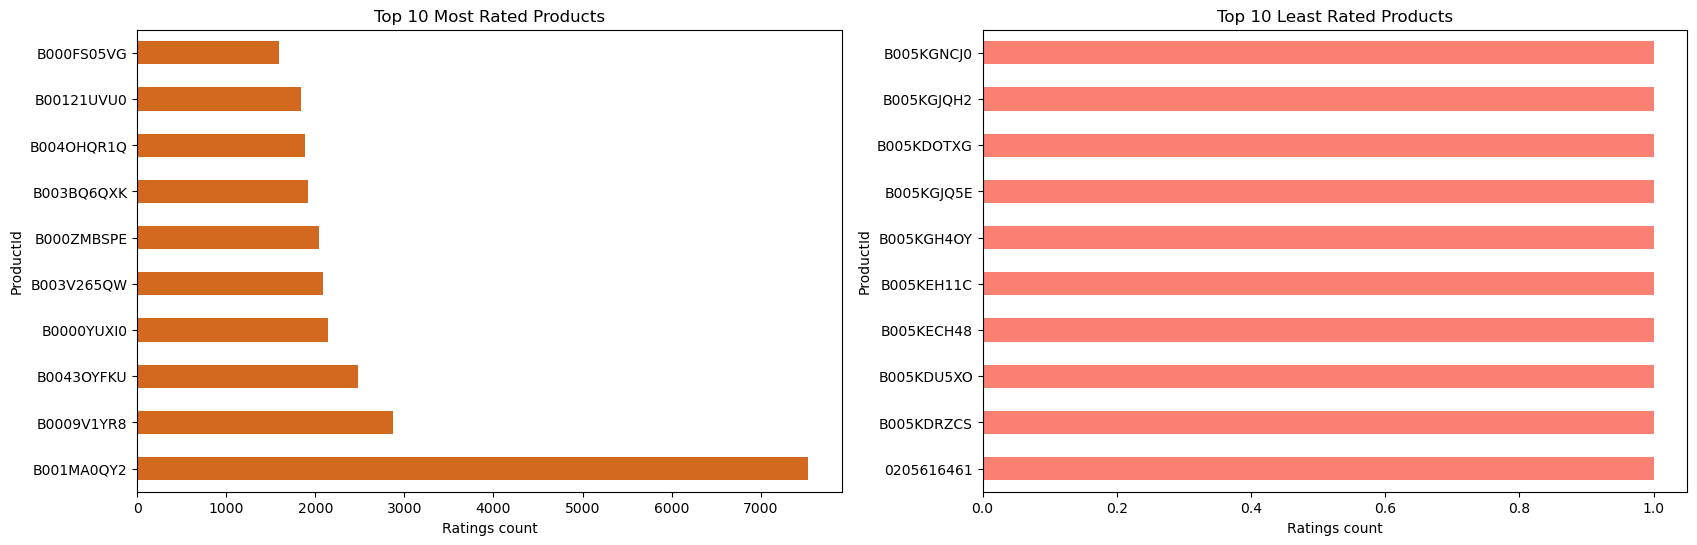

In [25]:
# Explore the most and least rated products
most_rated_products = (
    data.groupby("ProductId")["Rating"].count().sort_values(ascending=False).head(10)
)
least_rated_products = (
    data.groupby("ProductId")["Rating"].count().sort_values(ascending=True).head(10)
)

# Plot most and least rated products
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
most_rated_products.plot(kind="barh", color="chocolate")
plt.xlabel("Ratings count")
plt.title("Top 10 Most Rated Products")

plt.subplot(1, 2, 2)
least_rated_products.plot(kind="barh", color="salmon")
plt.xlabel("Ratings count")
plt.title("Top 10 Least Rated Products")

plt.show()